##   ASTROINFORME ML | CLASIFICACIÓN

#   Filtro de Habitabilidad Exoplanetario

Implementando un modelo de Machine Learning para identificar los candidatos con mayor potencial de vida.

##  El Problema: El cuello de botella de JWST

Las misiones de detección como Kepler y TESS han confirmado miles de exoplanetas. Sin embargo, solo una fracción de ellos son mundos rocosos templados (posiblemente habitables). El Telescopio Espacial James Webb (JWST) tiene la capacidad de analizar atmósferas, pero su tiempo de operación es extremadamente limitado y costoso.

### Objetivo
Crear un sistema de priorización que filtre automáticamente los candidatos más prometedores para el análisis atmosférico avanzado del JWST. He programado un generador que simula 1,500 exoplanetas siguiendo reglas astrofísicas simplificadas para crear las 4 clases.

##  Componentes Clave del Modelo

📏
Features (Variables X)
**Los datos de entrada que el modelo utiliza para hacer su predicción**
*   Radio Planetario (R⊕, Radios Terrestres)
*   Temperatura de Equilibrio (K, Distancia a la Estrella)

🎯
Variable Objetivo (Variable Y)
**El resultado o etiqueta que el modelo debe predecir**
*   Clase de Exoplaneta:
    *   Gigantes Gaseosos: Radios muy grandes (como Júpiter)
    *   Mundos Helados: Rocosos pero muy fríos (< 200 Kelvin)
    *   Infiernos Rocosos: Rocosos pero demasiado calientes (> 400 Kelvin)
    *   Candidatos Habitables: Tamaño terrestre y temperatura templada (La zona "Ricitos de Oro")

🧠
Tipo de Tarea de ML
**La naturaleza de la variable objetivo determina la tarea**
                CLASIFICACIÓN MULTICLASE
Clasificamos el planeta en uno de varios tipos discretos, no solo "sí/no"

---

#   1.  Generación de Datos Sintéticos

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de semilla para reproducibilidad
np.random.seed(42)

# Generar 1500 Planetas
n_samples = 1500

# GENERACIÓN DE FEATURES (X)
# Radio (En Radios Terrestres - Re): Usamos distribución log-normal (hay más planetas pequeños que gigantes)
radius = np.random.lognormal(mean=0.5, sigma=0.7, size=n_samples)

# Temperatura de Equilibrio (Kelvin): Desde congelados (50K) hasta lava (2500K)
temp = np.random.uniform(50, 2500, size=n_samples)

# DEFINICIÓN DE CLASES (Variable Objetivo y)
def clasificar_planeta(r, t):
    # Regla 1: Si es muy grande, es un Gigante Gaseoso (independiente de la temperatura)
    if r > 4.0:
        return 'Gigante Gaseoso'
    
    # Si es pequeño (Rocoso o Super-Tierra)... miramos la temperatura:
    
    # Regla 2: Demasiado caliente
    if t > 400: # Más de 127°C aprox
        return 'Infierno Rocoso'
    
    # Regla 3: Demasiado frío
    if t < 200: # Menos de -73°C aprox
        return 'Mundo Helado'
    
    # Regla 4: Zona Habitable (Goldilocks Zone)
    # Entre 200K y 400K, y Radio < 4.0
    return 'Candidato Habitable'

# Aplicamos la clasificación
planet_types = [clasificar_planeta(r, t) for r, t in zip(radius, temp)]

# Creamos el DataFrame
df = pd.DataFrame({
    'Radio_Re': radius,
    'Temperatura_K': temp,
    'Clase': planet_types
})

# Guardamos el archivo en la carpeta data
# OJO: Asegúrate de tener la carpeta 'data' creada
try:
    df.to_csv('../data/exoplanets.csv', index=False)
    print("✅ Archivo 'exoplanets.csv' generado exitosamente en la carpeta 'data'.")
    display(df.head())
    print("\nConteo de Clases:")
    print(df['Clase'].value_counts())
except FileNotFoundError:
    print("❌ Error: No se encontró la carpeta 'data'. Por favor créala antes de correr esto.")

✅ Archivo 'exoplanets.csv' generado exitosamente en la carpeta 'data'.


,Radio_Re,Temperatura_K,Clase
0,2.334272,711.060764,Infierno Rocoso
1,1.496629,2071.371055,Infierno Rocoso
2,2.594469,1270.726422,Infierno Rocoso
3,4.788039,238.792784,Gigante Gaseoso
4,1.399469,193.449777,Mundo Helado



Conteo de Clases:
Clase
Infierno Rocoso        1130
Gigante Gaseoso         167
Candidato Habitable     116
Mundo Helado             87
Name: count, dtype: int64


#   2.  Análisis Exploratorio Visual (El Mapa de la Galaxia)

*   Eje X: Temperatura
*   Eje Y: Radio
*   Colores: La Clase del planeta

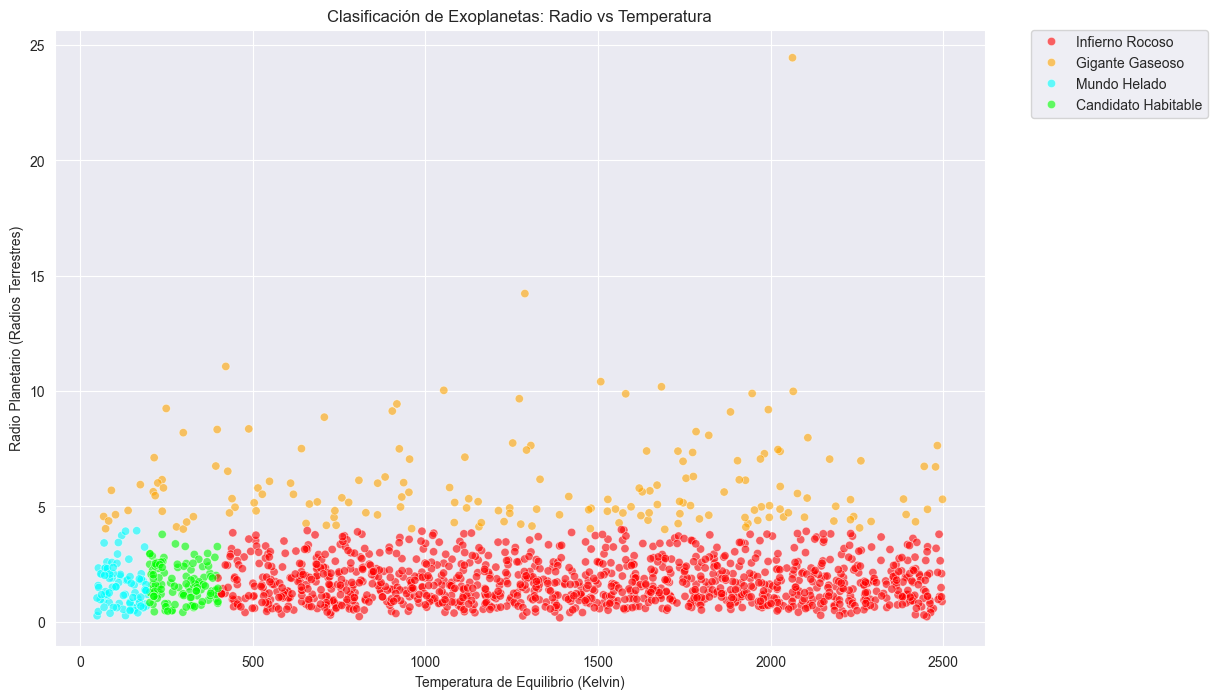

In [7]:
# Configuración estética para espacio exterior
sns.set_style("darkgrid")

plt.figure(figsize=(12, 8))

# Gráfico de Dispersión
# hue: Colorea por clase
# palette: Elegimos colores lógicos (Rojo=Infierno, Azul=Helado, Verde=Habitable, Naranja=Gigante)
colores_planetas = {
    'Infierno Rocoso': 'red', 
    'Mundo Helado': 'cyan', 
    'Candidato Habitable': 'lime', 
    'Gigante Gaseoso': 'orange'
}

sns.scatterplot(data=df, x='Temperatura_K', y='Radio_Re', hue='Clase', palette=colores_planetas, alpha=0.6)

plt.title("Clasificación de Exoplanetas: Radio vs Temperatura")
plt.xlabel("Temperatura de Equilibrio (Kelvin)")
plt.ylabel("Radio Planetario (Radios Terrestres)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Leyenda afuera para no tapar
plt.show()


#   3.  Escalado

Si observamos los datos:
*   **Temperatura:** Va de 50 a 2500 (Rango de miles).
*   **Radio:** Va de 0.5 a 15 (Rango de unidades).

La variable **Temperatura** "grita" mucho más fuerte que el **Radio** simplemente porque sus números son más grandes. Si no arreglamos esto, el modelo ignorará el tamaño del planeta.

**La Solución:** `StandardScaler`.
Vamos a transformar los datos para que ambas variables "hablen el mismo idioma" (tengan media 0 y desviación estándar 1).

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar X e y
X = df[['Radio_Re', 'Temperatura_K']]
y = df['Clase']

# División Train/Test (Rigurosidad científica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ESCALADO DE DATOS (¡Vital para KNN!)
scaler = StandardScaler()

# Ajustamos el escalador solo con los datos de ENTRENAMIENTO y transformamos ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos a DataFrame solo para ver cómo quedaron (Opcional, pero didáctico)
df_scaled_preview = pd.DataFrame(X_train_scaled, columns=['Radio_Scaled', 'Temp_Scaled'])
print("--- Datos después de StandardScaler (Primeras filas) ---")
display(df_scaled_preview.head())

--- Datos después de StandardScaler (Primeras filas) ---


,Radio_Scaled,Temp_Scaled
0,-1.042409,-0.270139
1,0.669543,0.114264
2,-0.173545,0.298784
3,0.494240,-0.353581
4,-0.786658,0.942946


#   4.   El Método del Codo

Ahora viene la gran pregunta: ¿Cuántos vecinos debe consultar el algoritmo?
*   Si K = 1: El modelo es muy nervioso (se deja llevar por el vecino más cercano, aunque sea un error).
*   Si K=100: El modelo se diluye (promedia demasiado y pierde detalle).

Vamos a probar con K desde 1 hasta 40 y graficar el error para ver cuál es el mejor número.

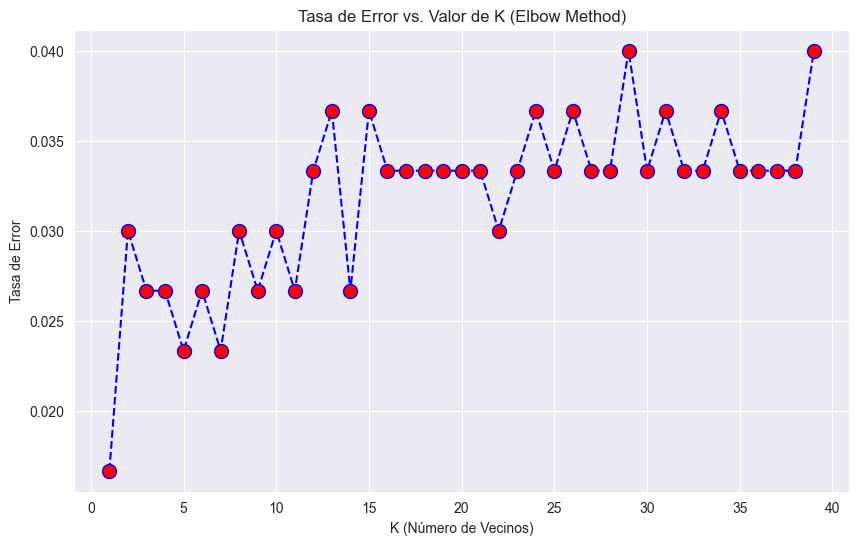

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Vamos a guardar la tasa de error para cada K
tasa_error = []

# Probamos K desde 1 hasta 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    # Calculamos el promedio de veces que la predicción fue distinta al valor real
    tasa_error.append(np.mean(pred_i != y_test))

# Graficamos el resultado
plt.figure(figsize=(10,6))
plt.plot(range(1, 40), tasa_error, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Tasa de Error vs. Valor de K (Elbow Method)')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('Tasa de Error')
plt.show()

#   5.  Entrenar el Modelo Final

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Entrenar el modelo final con K=5
knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(X_train_scaled, y_train)

# Predecir
pred_final = knn_final.predict(X_test_scaled)

# Evaluar
print("=== Matriz de Confusión ===")
print(confusion_matrix(y_test, pred_final))
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, pred_final))

=== Matriz de Confusión ===
[[ 21   0   1   0]
 [  0  32   1   0]
 [  3   0 226   0]
 [  1   1   0  14]]

=== Reporte de Clasificación ===
                     precision    recall  f1-score   support

Candidato Habitable       0.84      0.95      0.89        22
    Gigante Gaseoso       0.97      0.97      0.97        33
    Infierno Rocoso       0.99      0.99      0.99       229
       Mundo Helado       1.00      0.88      0.93        16

           accuracy                           0.98       300
          macro avg       0.95      0.95      0.95       300
       weighted avg       0.98      0.98      0.98       300



# CONCLUSIONES🌟

1.  **Exactitud Global (Accuracy): 98%**.
    *   El modelo es extremadamente sólido. Entendió perfectamente las reglas físicas que programamos.

2.  **El caso crítico: "Candidato Habitable"**
    *   **Recall (0.95):** De los 22 mundos habitables reales que había en el set de prueba, **el modelo encontró 21**. ¡Solo se nos escapó 1! Esto es excelente para la misión del JWST, no estamos perdiendo oportunidades.
    *   **Precision (0.84):** Aquí está el detalle. El modelo dijo "¡He encontrado 25 habitables!", pero en realidad solo 21 lo eran.
    *   **¿Qué pasó?** Si miras la primera columna de la matriz, verás que el modelo confundió **3 "Infiernos Rocosos"** y **1 "Mundo Helado"** con habitables.
    *   **Interpretación Física:** Esos planetas probablemente estaban justo en el borde ("frontera") de la zona habitable (ej: 399 Kelvin o 201 Kelvin). Como KNN mira a los vecinos, si un planeta está en la frontera, puede confundirse fácilmente.